In [2]:
# bases
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

# to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
from plotly.offline import iplot, init_notebook_mode

#text mining
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

## 1.2 Listings des Dataframes :


In [3]:
listings = pd.read_csv("/Users/Coco/Documents/Simplon/PycharmProjects/airbnb_paris/Sources/listings.csv")
listings_details = pd.read_csv("/Users/Coco/Documents/Simplon/PycharmProjects/airbnb_paris/Sources/listings_2.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("/Users/Coco/Documents/Simplon/PycharmProjects/airbnb_paris/Sources/calendar.csv", parse_dates=['date'])
reviews_details = pd.read_csv("/Users/Coco/Documents/Simplon/PycharmProjects/airbnb_paris/Sources/reviews_2.csv", parse_dates=['date'])

Séléction d'un ensemble de colonne qui me semble utile pour mon analyse

In [4]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness",
                  "review_scores_location", "review_scores_accuracy", "review_scores_communication",
                  "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost",
                  "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price",
                  "market"]

Création d'une Left Join sur l'ID avec une seulement le target colonne 

In [5]:
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')

listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))


In [6]:
listings.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
0,3109,zen and calm,3631,Anne,Observatoire,48.83349,2.31852,Entire home/apt,60,3,...,15,https://www.airbnb.com/rooms/3109,f,NaN,within a day,100.0,"Paris, Île-de-France, France",$490.00,NaN,Paris
1,5396,Explore the heart of old Paris,7903,Borzou,Hôtel-de-Ville,48.85100,2.35869,Entire home/apt,115,1,...,90,https://www.airbnb.com/rooms/5396,f,We are both journalists based in the Middle Ea...,within an hour,100.0,"Paris, Ile-de-France, France",$600.00,"$2,000.00",Paris
2,7397,MARAIS - 2ROOMS APT - 2/4 PEOPLE,2626,Franck,Hôtel-de-Ville,48.85758,2.35275,Entire home/apt,115,10,...,23,https://www.airbnb.com/rooms/7397,f,"I am a writer,51, author of novels, books of l...",within an hour,100.0,"Paris, Île-de-France, France",NaN,"$2,200.00",Paris
3,7964,Large & sunny flat with balcony !,22155,Anaïs,Opéra,48.87464,2.34341,Entire home/apt,130,6,...,365,https://www.airbnb.com/rooms/7964,f,Hello ! \r\nOur apartment is great and I am su...,NaN,NaN,"Paris, Île-de-France, France",NaN,NaN,Paris
4,8522,GREAT FLAT w/ CITY VIEW,25435,Adrien,Ménilmontant,48.86528,2.39326,Entire home/apt,90,3,...,365,https://www.airbnb.com/rooms/8522,f,"De Paris, propre et organisé.",NaN,NaN,"Paris, Ile-de-France, France",$600.00,NaN,Paris


## 2. Exploration des données
### 2.1 Visualiser quel quartier a le plus de Airbnb sur Paris

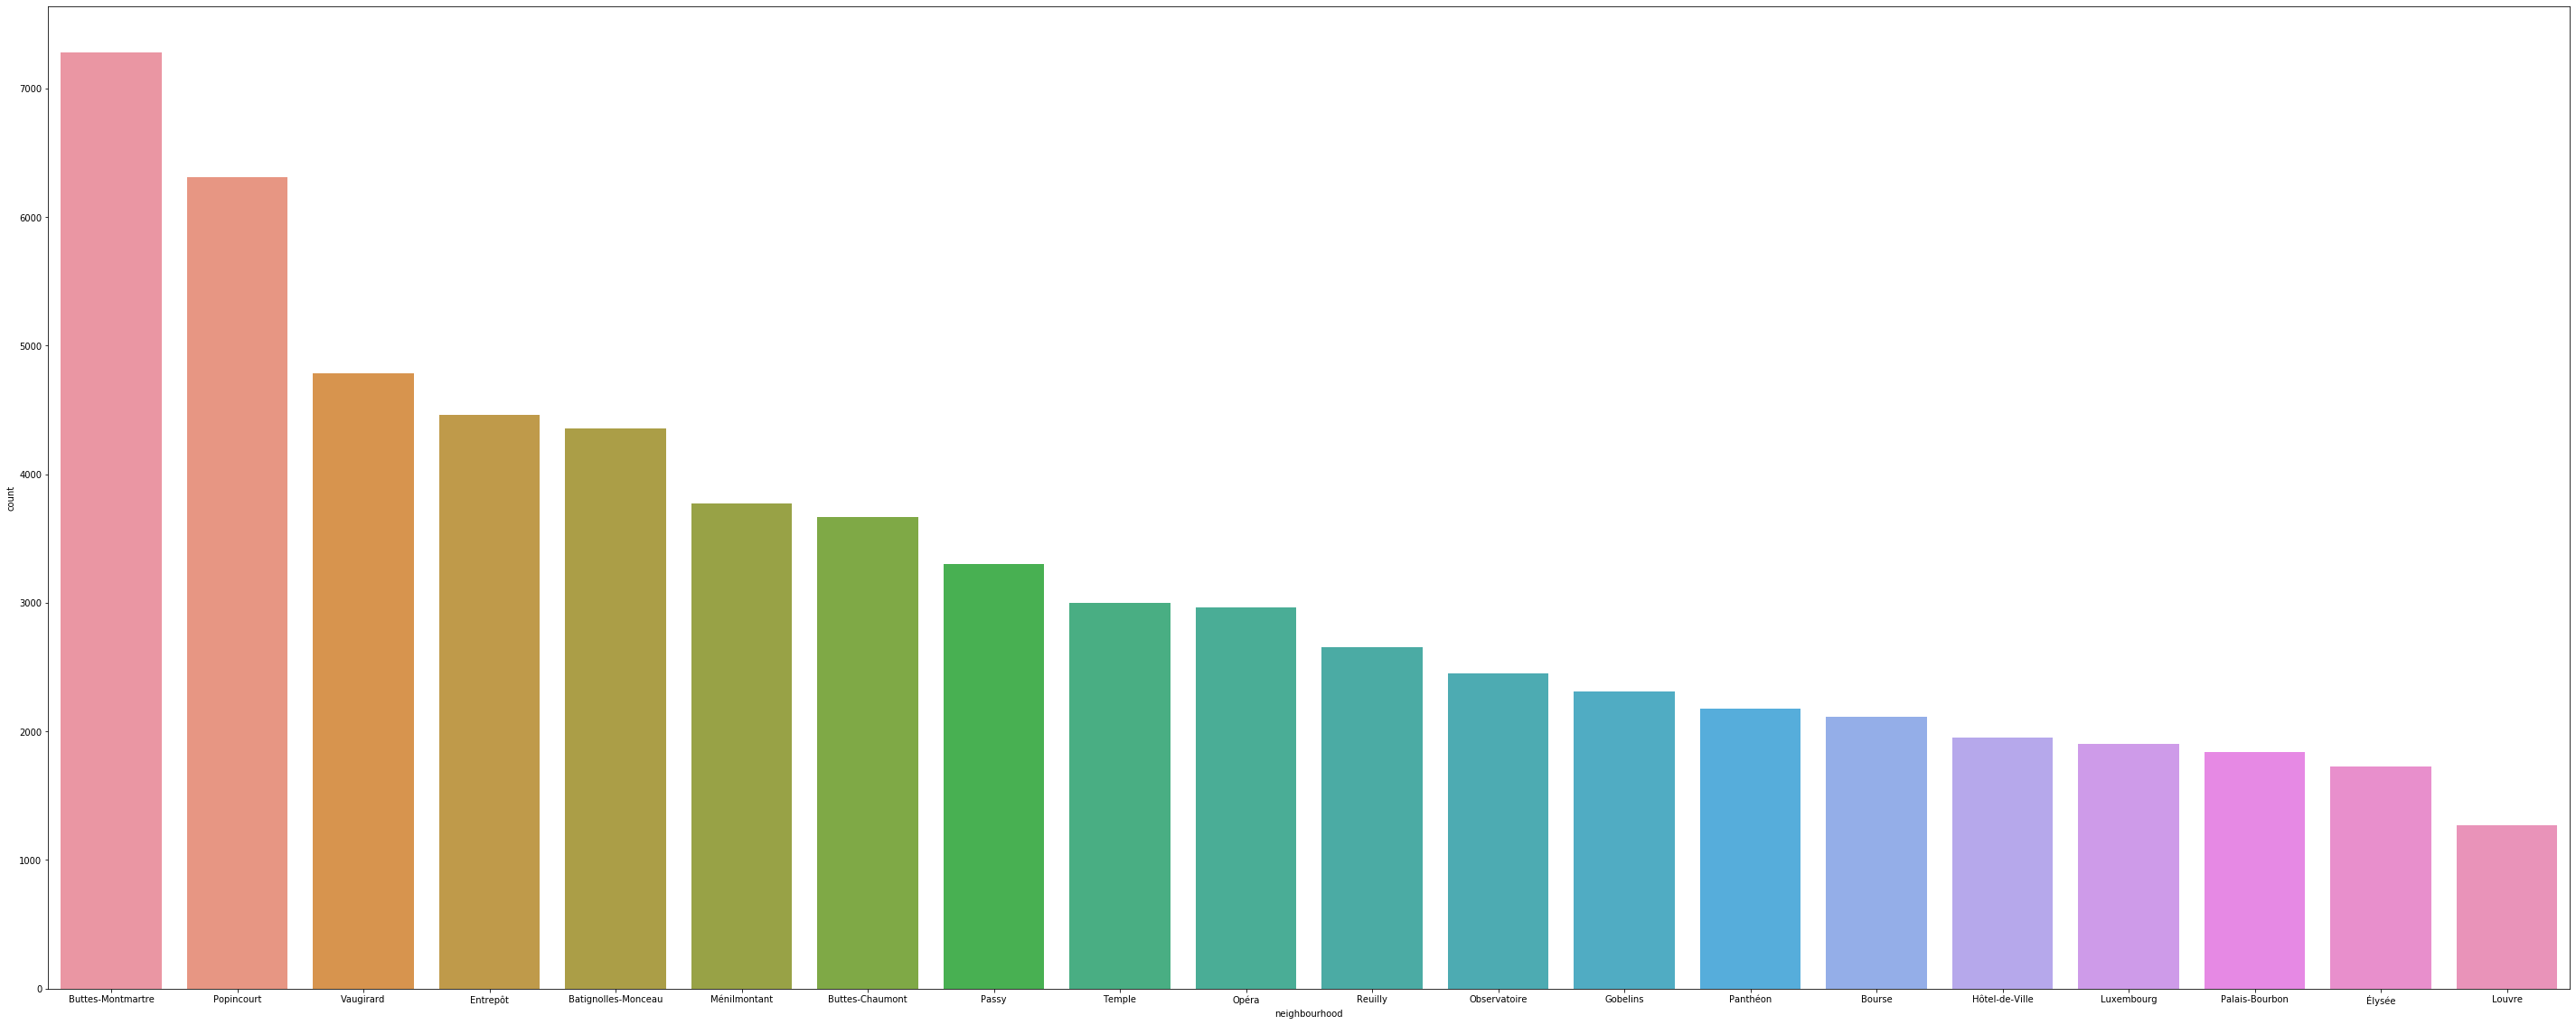

In [7]:
feq = listings['neighbourhood'].value_counts().sort_values(ascending=True)
plt.figure(figsize=(50,20))
sns.countplot(x="neighbourhood", data=listings, order = listings['neighbourhood'].value_counts().index)
plt.show()


Version avec Seaborn

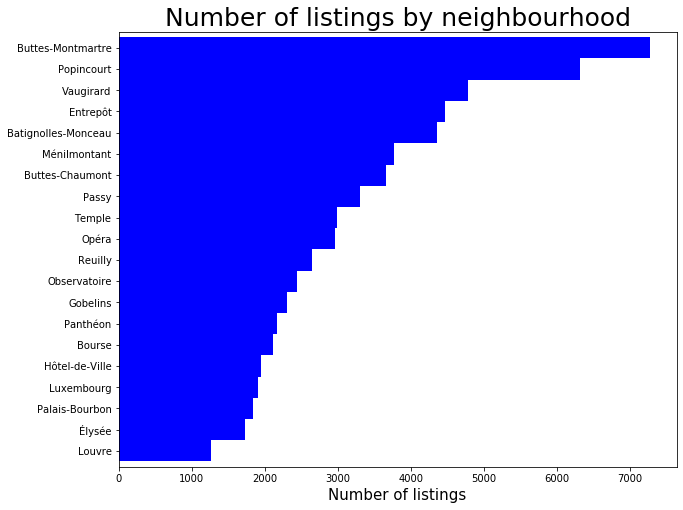

In [8]:
feq = listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=25)
plt.xlabel('Number of listings', fontsize=15)
plt.savefig('2.1_Neighbourhoods.png')

### 2.2 Créer une carte interactive pour visualiser le nombre  d'appartement par quartier

In [9]:
lats2019 = listings['latitude'].tolist()
lons2019 = listings['longitude'].tolist()
locations = list(zip(lats2019, lons2019))
map1 = folium.Map(location=[48.8534, 2.3488], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1.save('map1.html')

### 2.3 Etudier pour quel nombre de personne les locations sont le plus réservées 


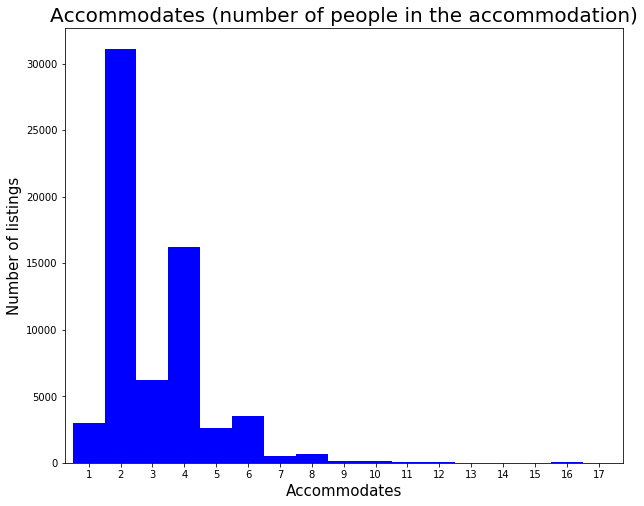

In [10]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people in the accommodation)", fontsize=20)
plt.ylabel('Number of listings', fontsize=15)
plt.xlabel('Accommodates', fontsize=15)
plt.savefig('2.3_Accommodates.png')

Ici nous avons créé une carte interactive sur uniquement les locations pour 2 personnes étant donné qu'il s'agit des logements les plus loués. 

In [11]:
adam = gpd.read_file("/Users/Coco/Documents/Simplon/PycharmProjects/airbnb_paris/Sources/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))


def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)


map3 = folium.Map(location=[48.8534, 2.3488], zoom_start=11)
folium.GeoJson(data=adam,
               name='Paris',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3.save('map3.html')

KeyError: 'neighbourhood'

### 2.4 Disponibilité à venir 


Pour la colonne availability False signifie déjà réservé ou bien indisponible à la réservation. 

In [ ]:
# affiche toutes les données non na
a = calendar[~calendar.price.isna()] 

In [ ]:
# affiche toutes les données avec ','
a[a.price.str.contains(',')]

In [ ]:
#nettoyage de la colonne price et création d'un échantillon par rapport à la date car trop de données
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2019-12-05']

print(calendar.shape)

listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

In [ ]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()






In [ ]:
test_altair = alt.Chart(sum_available).mark_area(
    color="lightblue",
    interpolate='step-after',
    line=True
).encode(
    x='date:N',
    y='available'
)

test_altair.save('sum_available.html')


### 2.5 Text mining des commentaires


En premier nettoyage de la dataframe reviews details. 

In [22]:
# supprimer les commentaires vides
reviews_details = reviews_details[reviews_details['comments'].notnull()]

# supprimer les nombres
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '')
# convertir en minuscule
reviews_details['comments'] = reviews_details['comments'].str.lower()
# supprimer les stopwords en Anglais (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split()
                                                      if i not in stop_english]))
# supprimer les stopwords en Français (from nltk library)
stop_french = stopwords.words("french")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split()
                                                      if i not in stop_french]))

reviews_details.comments.values[2]  # print le 3eme commentaire 


'tout s est bien déroulé merci bien pg'

Trouver les mots les plus utilisés

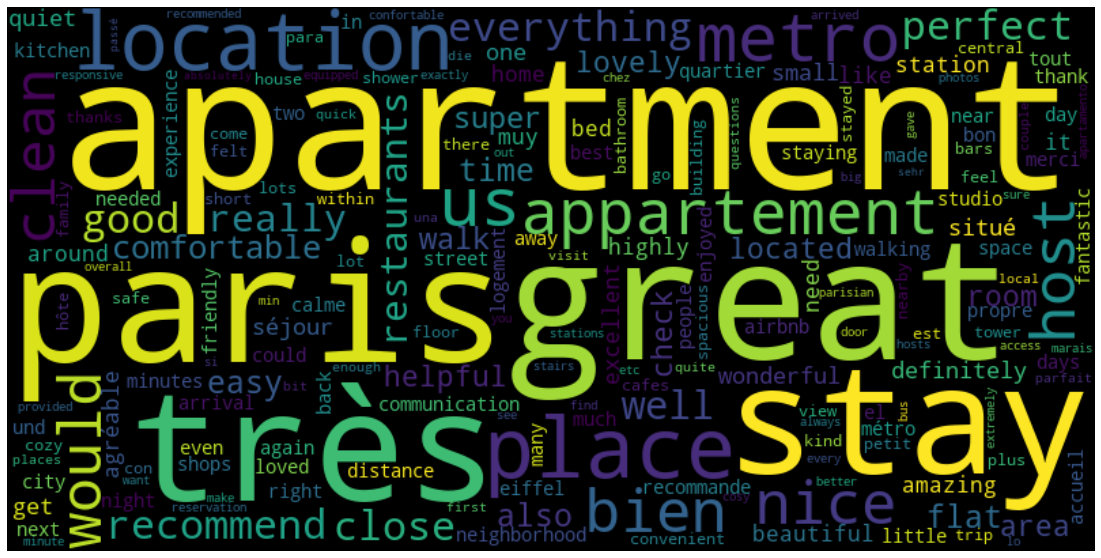

In [23]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)


cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('5_Most_Used_Word.png')